This notebook presents an application semi-physical model of the L1 laser in its second version, based on PyTorch.
In particular, in this notebook a simulation process is carried out to investigate the landscape of the loss function adopted for the optimisation process.

Author: Francesco Capuano, 2022 S17 summer intern @ ELI-beamlines, Prague

# Motivation

The goal of this project is to maximise second-harmonic efficiency. However, since this metric is also very much related to the shortest possible pulse shape, we started with developing a strategy to optimise a predefinite set of control parameters so as to minimise the difference between the obtained pulse shape (in the temporal domain) and a target one (which, by default, is the shortest one typically). 

However, since data are really expensive to empirically collect we resorted to model the underlying dynamics of the whole system, also considering that (even if not exhaustive) there is a significant amount of know-how concerned with the considered dynamics available.

After this model is obtained, it is possible to use it to obtain the desired control parameters.

In [3]:
import torch
# these import are necessary to import modules from directories one level back in the folder structure
import sys
sys.path.append("../..")
from utils.se import get_project_root
from utils.physics import extract_data
import matplotlib.pyplot as plt
from scipy.optimize import Bounds
import numpy as np

frequency, field = extract_data()

The preprocessing steps do not depend on the control parameters, therefore they can take place even in numpy

In [4]:
# preprocessing steps
from utils.physics import *
# preprocessing
cutoff = np.array((289.95, 291.91)) * 1e12
# cutting off the signal
frequency_clean, field_clean = cutoff_signal(frequency_cutoff = cutoff, frequency = frequency * 1e12,
                                             signal = field)
# augmenting the signal
frequency_clean_aug, field_clean_aug = equidistant_points(frequency = frequency_clean,
                                                          signal = field_clean,
                                                          num_points = int(3e3)) # n_points defaults to 5e3
# retrieving central carrier
central_carrier = central_frequency(frequency = frequency_clean_aug, signal = field_clean_aug)

However, to be used in the Computational Laser model, their tensor version is required

In [5]:
from utils.LaserModel_torch import ComputationalLaser as CL

intensity = torch.from_numpy(field ** 2)
frequency, field = torch.from_numpy(frequency_clean_aug), torch.from_numpy(field_clean_aug)
compressor_params = -1 * torch.tensor([267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50], dtype = torch.double)

laser = CL(frequency = frequency * 1e-12, field = field, compressor_params = compressor_params)
target_time, target_profile = laser.transform_limited()

In [6]:
def L1Loss(GDD, TOD, B:float=float(2)): 
    """
    This function computes the L1-Loss corresponding to a given value of GDD and TOD.
    """
    control = torch.stack([GDD,TOD,torch.tensor(9.54893 * 1e-50)])
    # overwrite the value of B with input one
    laser.B = B
    _, controlled_profile = laser.forward_pass(control)
    return (torch.abs((controlled_profile.cuda() - target_profile.cuda()))).sum()

def L2Loss(GDD, TOD, B:float=float(2)): 
    """
    This function computes the L2-Loss corresponding to a given value of GDD and TOD.
    """
    control = torch.stack([GDD,TOD,torch.tensor(9.54893 * 1e-50)])
    laser.B = B
    _, controlled_profile = laser.forward_pass(control)
    return ((controlled_profile.cuda() - target_profile.cuda())**2).mean()

In [7]:
from scipy.optimize import Bounds
bounds_control = Bounds(
                    # GDD         # TOD          # FOD
            lb = (2.3522e-22, -1.003635e-34, 4.774465e-50),
            ub = (2.99624e-22, 9.55955e-35, 1.4323395e-49)
        )

first_two_lower, first_two_upper = bounds_control.lb[:2], bounds_control.ub[:2]
bounds = torch.from_numpy(np.vstack((first_two_lower, first_two_upper)).T)

nsteps = 1000
GDD_linspace = torch.linspace(start = bounds[0,0], end = bounds[0,1], steps = nsteps)
TOD_linspace = torch.linspace(start = bounds[1,0], end = bounds[1,1], steps = nsteps)
GDD_mesh, TOD_mesh = torch.meshgrid(GDD_linspace, TOD_linspace, indexing = "ij")

The objective function could also be plotted when considered as a function of **GDD** and **TOD** only.

In [8]:
TL_grid = torch.from_numpy(np.loadtxt("simulations/B=2/L1Loss.txt"))

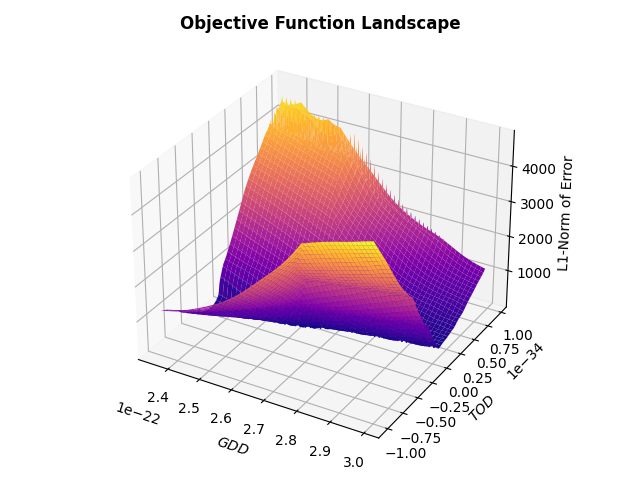

In [9]:
%matplotlib widget
my_map = "plasma"
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_xlabel(r"$GDD$"); ax.set_ylabel(r"$TOD$"); ax.set_zlabel("L1-Norm of Error")

surf = ax.plot_surface(GDD_mesh.numpy(), TOD_mesh.numpy(), TL_grid.numpy(), cmap = my_map)

ax.set_title("Objective Function Landscape", fontweight = "bold")

fig.tight_layout()
plt.show()

A contour plot of the log of the loss function landscape can give some more insights on the optimisation process and nature of loss functions.

/var/folders/_q/f5yqvnj16qn6cpl52jqqlxbr0000gn/T/ipykernel_5990/2338390084.py:22: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(cset0)


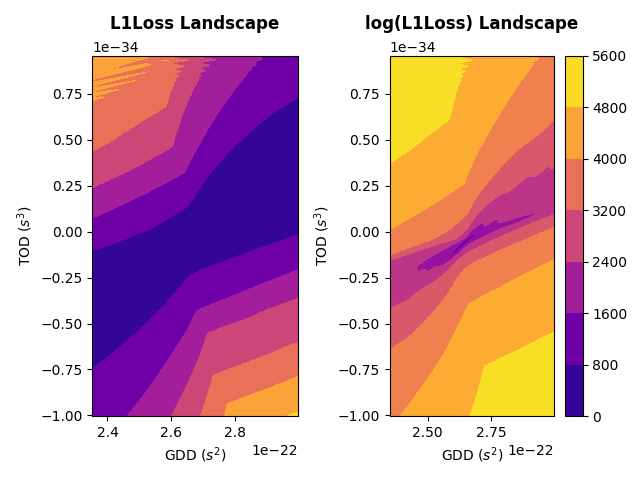

In [10]:
fig, ax = plt.subplots(ncols = 2)

cset0 = ax[0].contourf(
    GDD_mesh.numpy(), 
    TOD_mesh.numpy(), 
    TL_grid.numpy(),
    cmap = my_map
)

cset1 = ax[1].contourf(
    GDD_mesh.numpy(), 
    TOD_mesh.numpy(), 
    np.log(TL_grid.numpy()),
    cmap = my_map
)

ax[0].set_title("L1Loss Landscape", y=1.05, fontweight = "bold")
ax[0].set_xlabel(r"GDD ($s^2$)"); ax[0].set_ylabel(r"TOD ($s^3$)")
ax[1].set_title("log(L1Loss) Landscape", y=1.05, fontweight = "bold")
ax[1].set_xlabel(r"GDD ($s^2$)"); ax[1].set_ylabel(r"TOD ($s^3$)")

fig.colorbar(cset0)
fig.tight_layout()

plt.show()

This shows that the regular L1Loss offers various saddle points which are equally good for reducing the error. However, if the landscape passes through a monotic transformation such as $\log$, then the region in which the minimal lies is drastically reduced in size. This thing would eventually drive the optimizer to a much better optimal point. From this point on, every visualization will present the log-loss. 

Moreover, it is interesting to see how the log-loss landscape changes when B-integral assumes different values.
To this scope, a custom simulation process has been carried out. 
In this notebook, the the graphical results of these simulations are present.

In [11]:
def simulate_landscape(B:float=float(2), loss=L1Loss) -> None: 
    """
    This function simulates the function considering as control parameters GDD and TOD only for various levels
    of B-integral. This is done in the sake of studying how this parameters affects the optimisation process, 
    even in a simulated environment. 
    """
    nsteps = 1000
    GDD_linspace = torch.linspace(start = bounds[0,0], end = bounds[0,1], steps = nsteps)
    TOD_linspace = torch.linspace(start = bounds[1,0], end = bounds[1,1], steps = nsteps)
    GDD_mesh, TOD_mesh = torch.meshgrid(GDD_linspace, TOD_linspace, indexing = "ij")

    TL_grid = torch.empty(size = (nsteps, nsteps))
    # populating the mesh grid with values of L1 Loss per each combination of GDD and TOD considered
    from tqdm import tqdm
    combinations = []
    for i in tqdm(range(len(GDD_linspace))): 
        gdd = GDD_linspace[i]
        for j in range(len(TOD_linspace)): 
            tod = TOD_linspace[j]
            TL_grid[i,j] = loss(gdd, tod, B).detach()
            combinations.append((gdd, tod))
            
    np.savetxt(X = TL_grid.numpy(), fname = f"simulations/B={B}/{str(loss).split()[1]}.txt")

Various levels of B-integral are here tested, with a density which is higher in neighbourhoods of the most likely value (around 2 for L1 pump).

In [ ]:
from itertools import product 

Bs = (1., 1.5, 2, 2.5, 4., 8.)
losses = (L1Loss, L2Loss)

figL1, axL1 = plt.subplots(figsize = (8,8), nrows = 3, ncols = 2)
figL2, axL2 = plt.subplots(figsize = (8,8), nrows = 3, ncols = 2)

cell_map = {
    0 : (0,0), 
    1 : (0,1),
    2 : (1,0), 
    3 : (1,1), 
    4 : (2,0), 
    5 : (2,1), 
}

indL1, indL2 = 0, 0
for config in product(Bs, losses):
    B, loss = config
    loss = str(loss).split()[1]
    
    SIMULATION = np.loadtxt(fname = f"simulations/B={B}/{loss}.txt")
    
    if loss.startswith("L1"): 
        current = axL1[cell_map[indL1]]
        current.set_title(f"B={B}")
        current.set_xlabel(r"GDD ($s^2$)"); current.set_ylabel(r"TOD ($s^3$)")
        
        csetL1 = current.contourf(
            GDD_mesh.numpy(), 
            TOD_mesh.numpy(), 
            np.log(SIMULATION), 
            cmap = my_map, 
            zorder = 1
        )
        csetL1_empty = current.contour(
            GDD_mesh.numpy(), 
            TOD_mesh.numpy(), 
            np.log(SIMULATION),
            zorder = 2, 
            colors = "grey",
            linestyles = "solid"
        )
        
        current.clabel(csetL1_empty, np.unique(csetL1_empty.levels[::2]), colors = "white", fontsize=10, zorder = 3)
        indL1 += 1
        
    figL1.suptitle("L1-Loss Landscape for different values of B-integral", fontsize = 12, fontweight = "bold")
    figL1.tight_layout()

    if loss.startswith("L2"): 
        current = axL2[cell_map[indL2]]
        current.set_title(f"B={B}")
        current.set_xlabel(r"GDD ($s^2$)"); current.set_ylabel(r"TOD ($s^3$)")
        
        cset = current.contourf(
            GDD_mesh.numpy(), 
            TOD_mesh.numpy(), 
            np.log(SIMULATION), 
            cmap = my_map,
            zorder = 1
        )
        
        csetL2_empty = current.contour(
            GDD_mesh.numpy(), 
            TOD_mesh.numpy(), 
            np.log(SIMULATION),
            zorder = 2, 
            colors = "grey",
            linestyles = "solid"
        )
        
        current.clabel(csetL2_empty, np.unique(csetL2_empty.levels[::2]), colors = "white", fontsize=10, zorder = 3)
    
        indL2 += 1
    
    figL2.suptitle("L2-Loss Landscape for different values of B-integral", fontsize = 12, fontweight = "bold")    
    figL2.tight_layout()